In [1]:
import math
from collections import Counter

train_pred_file = "../../model_train_2.json.result"
test_pred_file = "../../model_test_2.json.result"

test_labels_file = "labels_test_set_clean.txt"
background_label = "0"

In [2]:
def compute_state_frequencies(state_sequences):
    states = []
    for state_sequence in state_sequences:
        states += state_sequence

    return Counter(states)

def compute_rolling_anomaly_score(test_state_sequences, state_frequency_train):
    anomaly_scores = []
    sequence_anomaly_scores = []
    test_state_counts = Counter()
    total_count_from_train = sum(state_frequency_train.values())

    for state_sequence in test_state_sequences:
        sequence_score = 0.0
        seq_anom_score = []
        for state in state_sequence:
            state_score = math.log(test_state_counts[state] + 1)
            state_score -= math.log(state_frequency_train[state] + 1)
            state_score += math.log(total_count_from_train + 1)
            state_score -= math.log(len(test_state_counts.keys()) + 1)
            test_state_counts[state] += 1
            sequence_score += state_score
            seq_anom_score.append(state_score)
        
        sequence_anomaly_scores.append(seq_anom_score)
        anomaly_scores.append(sequence_score)

    return anomaly_scores, sequence_anomaly_scores

def parse_flexfringe_result(ff):
    state_sequences = list()
    for i, line in enumerate(open(ff, "rt")):
        if i == 0:
            # the header
            line = line.split(";")
            for j in range(len(line)):
                line[j] = line[j].strip()
                if line[j] == "state sequence":
                    ss_idx = j
            continue
        
        ss = line.split(";")[ss_idx].strip()
        state_sequences.append(ss.strip().strip("[").strip("]").split(","))
    return state_sequences

In [3]:
train_sequences = parse_flexfringe_result(train_pred_file)
test_sequences = parse_flexfringe_result(test_pred_file)

# Get training results

In [4]:
train_state_counts = compute_state_frequencies(train_sequences)
                
# print('Computing anomaly scores...')
anomaly_scores, sequence_anomaly_scores = compute_rolling_anomaly_score(test_sequences, train_state_counts)

# Get labels and plot

In [5]:
test_labels = list()
print("Labels")
for i, line in enumerate(open(test_labels_file, "rt")):
    if i == len(test_sequences):
        break
    if line.split()[-1] != background_label:
        test_labels.append(1)
    else:
        test_labels.append(0)

Labels


In [6]:
len(test_sequences), len(test_labels)

(5151895, 5151895)

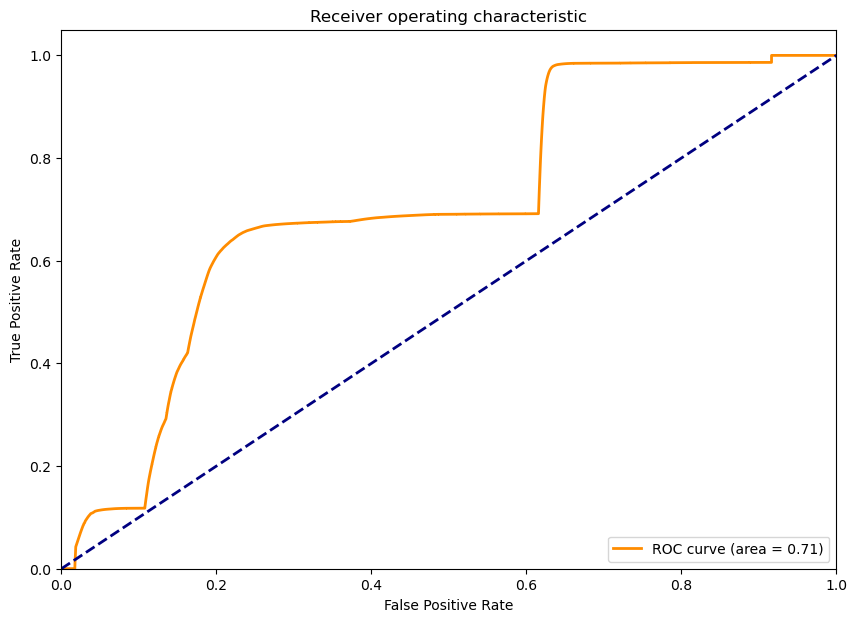

In [7]:
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score

score = anomaly_scores
labels = np.array(test_labels).reshape(-1, 1)

fpr, tpr, thresholds = roc_curve(labels, score)
roc_auc = roc_auc_score(labels, score)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")